In [29]:
import cv2
import math
import os
import imghdr
import optparse
import numpy as np
import matplotlib.pyplot as plt
import re
import imutils
# import time

from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
# from skew_detect import SkewDetect
from skimage import io
import pytesseract
from IPython.display import Image 


In [30]:
def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

def crop_around_center(image, width, height, rawangle):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    if rawangle >= -65 and rawangle <= 65:
        x1 = int(image_center[0] - width * 0.8)
        x2 = int(image_center[0] + width * 0.8)
        y1 = int(image_center[1] - height * 0.5)
        y2 = int(image_center[1] + height * 0.5)
    elif rawangle <= -65 and rawangle <= 135:
        x1 = int(image_center[0] - width * 0.6)
        x2 = int(image_center[0] + width * 0.6)
        y1 = int(image_center[1] - height * 0.8)
        y2 = int(image_center[1] + height * 0.8)
    else:
        x1 = int(image_center[0] - width * 0.5)
        x2 = int(image_center[0] + width * 0.5)
        y1 = int(image_center[1] - height * 0.5)
        y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        borderValue=(255,255,255)
    )

    return result


In [31]:
class SkewDetect:

    piby4 = np.pi / 4

    def __init__(
        self,
        input_file=None,
        batch_path=None,
        output_file=None,
        sigma=3.0,
        display_output=None,
        num_peaks=20,
        plot_hough=None
    ):

        self.sigma = sigma
        self.input_file = input_file
        self.batch_path = batch_path
        self.output_file = output_file
        self.display_output = display_output
        self.num_peaks = num_peaks
        self.plot_hough = plot_hough

    def write_to_file(self, wfile, data):

        for d in data:
            wfile.write(d + ': ' + str(data[d]) + '\n')
        wfile.write('\n')

    def get_max_freq_elem(self, arr):

        max_arr = []
        freqs = {}
        for i in arr:
            if i in freqs:
                freqs[i] += 1
            else:
                freqs[i] = 1

        sorted_keys = sorted(freqs, key=freqs.get, reverse=True)
        max_freq = freqs[sorted_keys[0]]

        for k in sorted_keys:
            if freqs[k] == max_freq:
                max_arr.append(k)

        return max_arr

    def display_hough(self, h, a, d):

        plt.imshow(
            np.log(1 + h),
            extent=[np.rad2deg(a[-1]), np.rad2deg(a[0]), d[-1], d[0]],
            cmap=plt.cm.gray,
            aspect=1.0 / 90)
        plt.show()

    def compare_sum(self, value):
        if value >= 44 and value <= 46:
            return True
        else:
            return False

    def display(self, data):

        for i in data:
            print(i + ": " + str(data[i]))

    def calculate_deviation(self, angle):

        angle_in_degrees = np.abs(angle)
        deviation = np.abs(SkewDetect.piby4 - angle_in_degrees)

        return deviation

    def run(self):

        if self.display_output:
            if self.display_output.lower() == 'yes':
                self.display_output = True
            else:
                self.display_output = False

        if self.plot_hough:
            if self.plot_hough.lower() == 'yes':
                self.plot_hough = True
            else:
                self.plot_hough = False

        if self.input_file is None:
            if self.batch_path:
                self.batch_process()
            else:
                print("Invalid input, nothing to process.")
        else:
            self.process_single_file()

    def check_path(self, path):

        if os.path.isabs(path):
            full_path = path
        else:
            full_path = os.getcwd() + '/' + str(path)
        return full_path

    def process_single_file(self):

        file_path = self.check_path(self.input_file)
        res = self.determine_skew(file_path)

        if self.output_file:
            output_path = self.check_path(self.output_file)
            wfile = open(output_path, 'w')
            self.write_to_file(wfile, res)
            wfile.close()

        return res

    def batch_process(self):

        wfile = None

        if self.batch_path == '.':
            self.batch_path = ''

        abs_path = self.check_path(self.batch_path)
        files = os.listdir(abs_path)

        if self.output_file:
            out_path = self.check_path(self.output_file)
            wfile = open(file_path, 'w')

        for f in files:
            file_path = abs_path + '/' + f
            if os.path.isdir(file_path):
                continue
            if imghdr.what(file_path):
                res = self.determine_skew(file_path)
                if wfile:
                    self.write_to_file(wfile, res)
        if wfile:
            wfile.close()

    def determine_skew(self, img_file):

        # img = io.imread(img_file, as_grey=True)
        import cv2
        img = cv2.imread(img_file, 0)
        edges = canny(img, sigma=self.sigma)
        h, a, d = hough_line(edges)
        _, ap, _ = hough_line_peaks(h, a, d, num_peaks=self.num_peaks)

        if len(ap) == 0:
            return {"Image File": img_file, "Message": "Bad Quality"}

        absolute_deviations = [self.calculate_deviation(k) for k in ap]
        average_deviation = np.mean(np.rad2deg(absolute_deviations))
        ap_deg = [np.rad2deg(x) for x in ap]

        bin_0_45 = []
        bin_45_90 = []
        bin_0_45n = []
        bin_45_90n = []

        for ang in ap_deg:

            deviation_sum = int(90 - ang + average_deviation)
            if self.compare_sum(deviation_sum):
                bin_45_90.append(ang)
                continue

            deviation_sum = int(ang + average_deviation)
            if self.compare_sum(deviation_sum):
                bin_0_45.append(ang)
                continue

            deviation_sum = int(-ang + average_deviation)
            if self.compare_sum(deviation_sum):
                bin_0_45n.append(ang)
                continue

            deviation_sum = int(90 + ang + average_deviation)
            if self.compare_sum(deviation_sum):
                bin_45_90n.append(ang)

        angles = [bin_0_45, bin_45_90, bin_0_45n, bin_45_90n]
        lmax = 0

        for j in range(len(angles)):
            l = len(angles[j])
            if l > lmax:
                lmax = l
                maxi = j

        if lmax:
            ans_arr = self.get_max_freq_elem(angles[maxi])
            ans_res = np.mean(ans_arr)

        else:
            ans_arr = self.get_max_freq_elem(ap_deg)
            ans_res = np.mean(ans_arr)

        data = {
            "Image File": img_file,
            "Average Deviation from pi/4": average_deviation,
            "Estimated Angle": ans_res,
            "Angle bins": angles}

        if self.display_output:
            self.display(data)

        if self.plot_hough:
            self.display_hough(h, a, d)
        return data

In [32]:
class Deskew:

    def __init__(self, input_file, display_image, output_file, r_angle):

        self.input_file = input_file
        self.display_image = display_image
        self.output_file = output_file
        self.r_angle = r_angle
        self.skew_obj = SkewDetect(self.input_file)

    #function by Karthik
    def inverte(self, imagem):
        imagem = (255 - imagem)
        #cv2.imwrite(name, imagem)
        return imagem


    def deskew(self):

        img = io.imread(self.input_file)
        res = self.skew_obj.process_single_file()
        image_height, image_width = img.shape[0:2]
        print('---Img height, width -------->{},{}', image_height, image_width)
        angle = res['Estimated Angle']
        print('Raw angle- {}', angle)

        rawangle = angle
        if angle >= 0 and angle <= 90:
            rot_angle = angle - 90 + self.r_angle
        if angle >= -45 and angle < 0:
            rot_angle = angle - 90 + self.r_angle
        if angle >= -90 and angle < -45:
            rot_angle = 90 + angle + self.r_angle

        # old for dskewing
        # rotated = rotate(img, rot_angle, resize=True, preserve_range=1) #very first implementation
        print('-----------rot_angle----------->{}', rot_angle)
        # for max rect eval
        # rotated = rotate_max_area(img, rot_angle)
        if abs(rot_angle) >= 86 and abs(rot_angle) <= 94:
            print('---No rotation required------')
            rotated = img
        elif abs(rot_angle) == 0:
            print('---No rotation required------')
            rotated = img
        else:
            print('---****Rotation required****------')
            # rotated = RotateAndFill(img, rot_angle) #working rotation commented to test new algo
            ###########################################

            # rot_angle = 360 - rot_angle
            image_rotated = rotate_image(img, rot_angle)
            rotated = crop_around_center(
                image_rotated,
                *largest_rotated_rect(
                    image_width,
                    image_height,
                    math.radians(angle)
                ), rawangle)
            ###########################################
        if self.display_image:
            self.display(rotated)

        if self.output_file:
            # self.saveImage(rotated*255)
            self.saveImage(rotated)
            print('------------self.output_file===>')
            print(self.output_file)
            image = cv2.imread(self.output_file)
            rot_data = pytesseract.image_to_osd(image)
            print("[OSD] " + rot_data)
            rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)

            angle = float(rot)
            # if angle > 0:
            #     angle = 360 - angle
            print("[ANGLE] " + str(angle))
            # # rotate the image to deskew it
            (h, w) = rotated.shape[:2]
            center = (w // 2, h // 2)

            rotated = imutils.rotate_bound(rotated, angle)
            # text = pytesseract.image_to_string(rotated, lang='eng')
            # print(text.encode(encoding='UTF-8'))
            self.saveImage(rotated)


    def saveImage(self, img):
        path = self.skew_obj.check_path(self.output_file)
        io.imsave(path, img.astype(np.uint8))

    def display(self, img):

        plt.imshow(img)
        plt.show()

    def run(self):

        if self.input_file:
            self.deskew()

In [37]:
input_file = '/home/ustuser/official/AIBeta/smartvision2021/hackathon/NameNormImg/testimage/V2_Mask_Mild_orient_1.1.jpg'
display_image = None
output_file = '/home/ustuser/official/AIBeta/smartvision2021/hackathon/NameNormImg/testimage_output/Jupy_rotated_V2_Mask_Mild_orient_1.1.jpg'
r_angle = 0


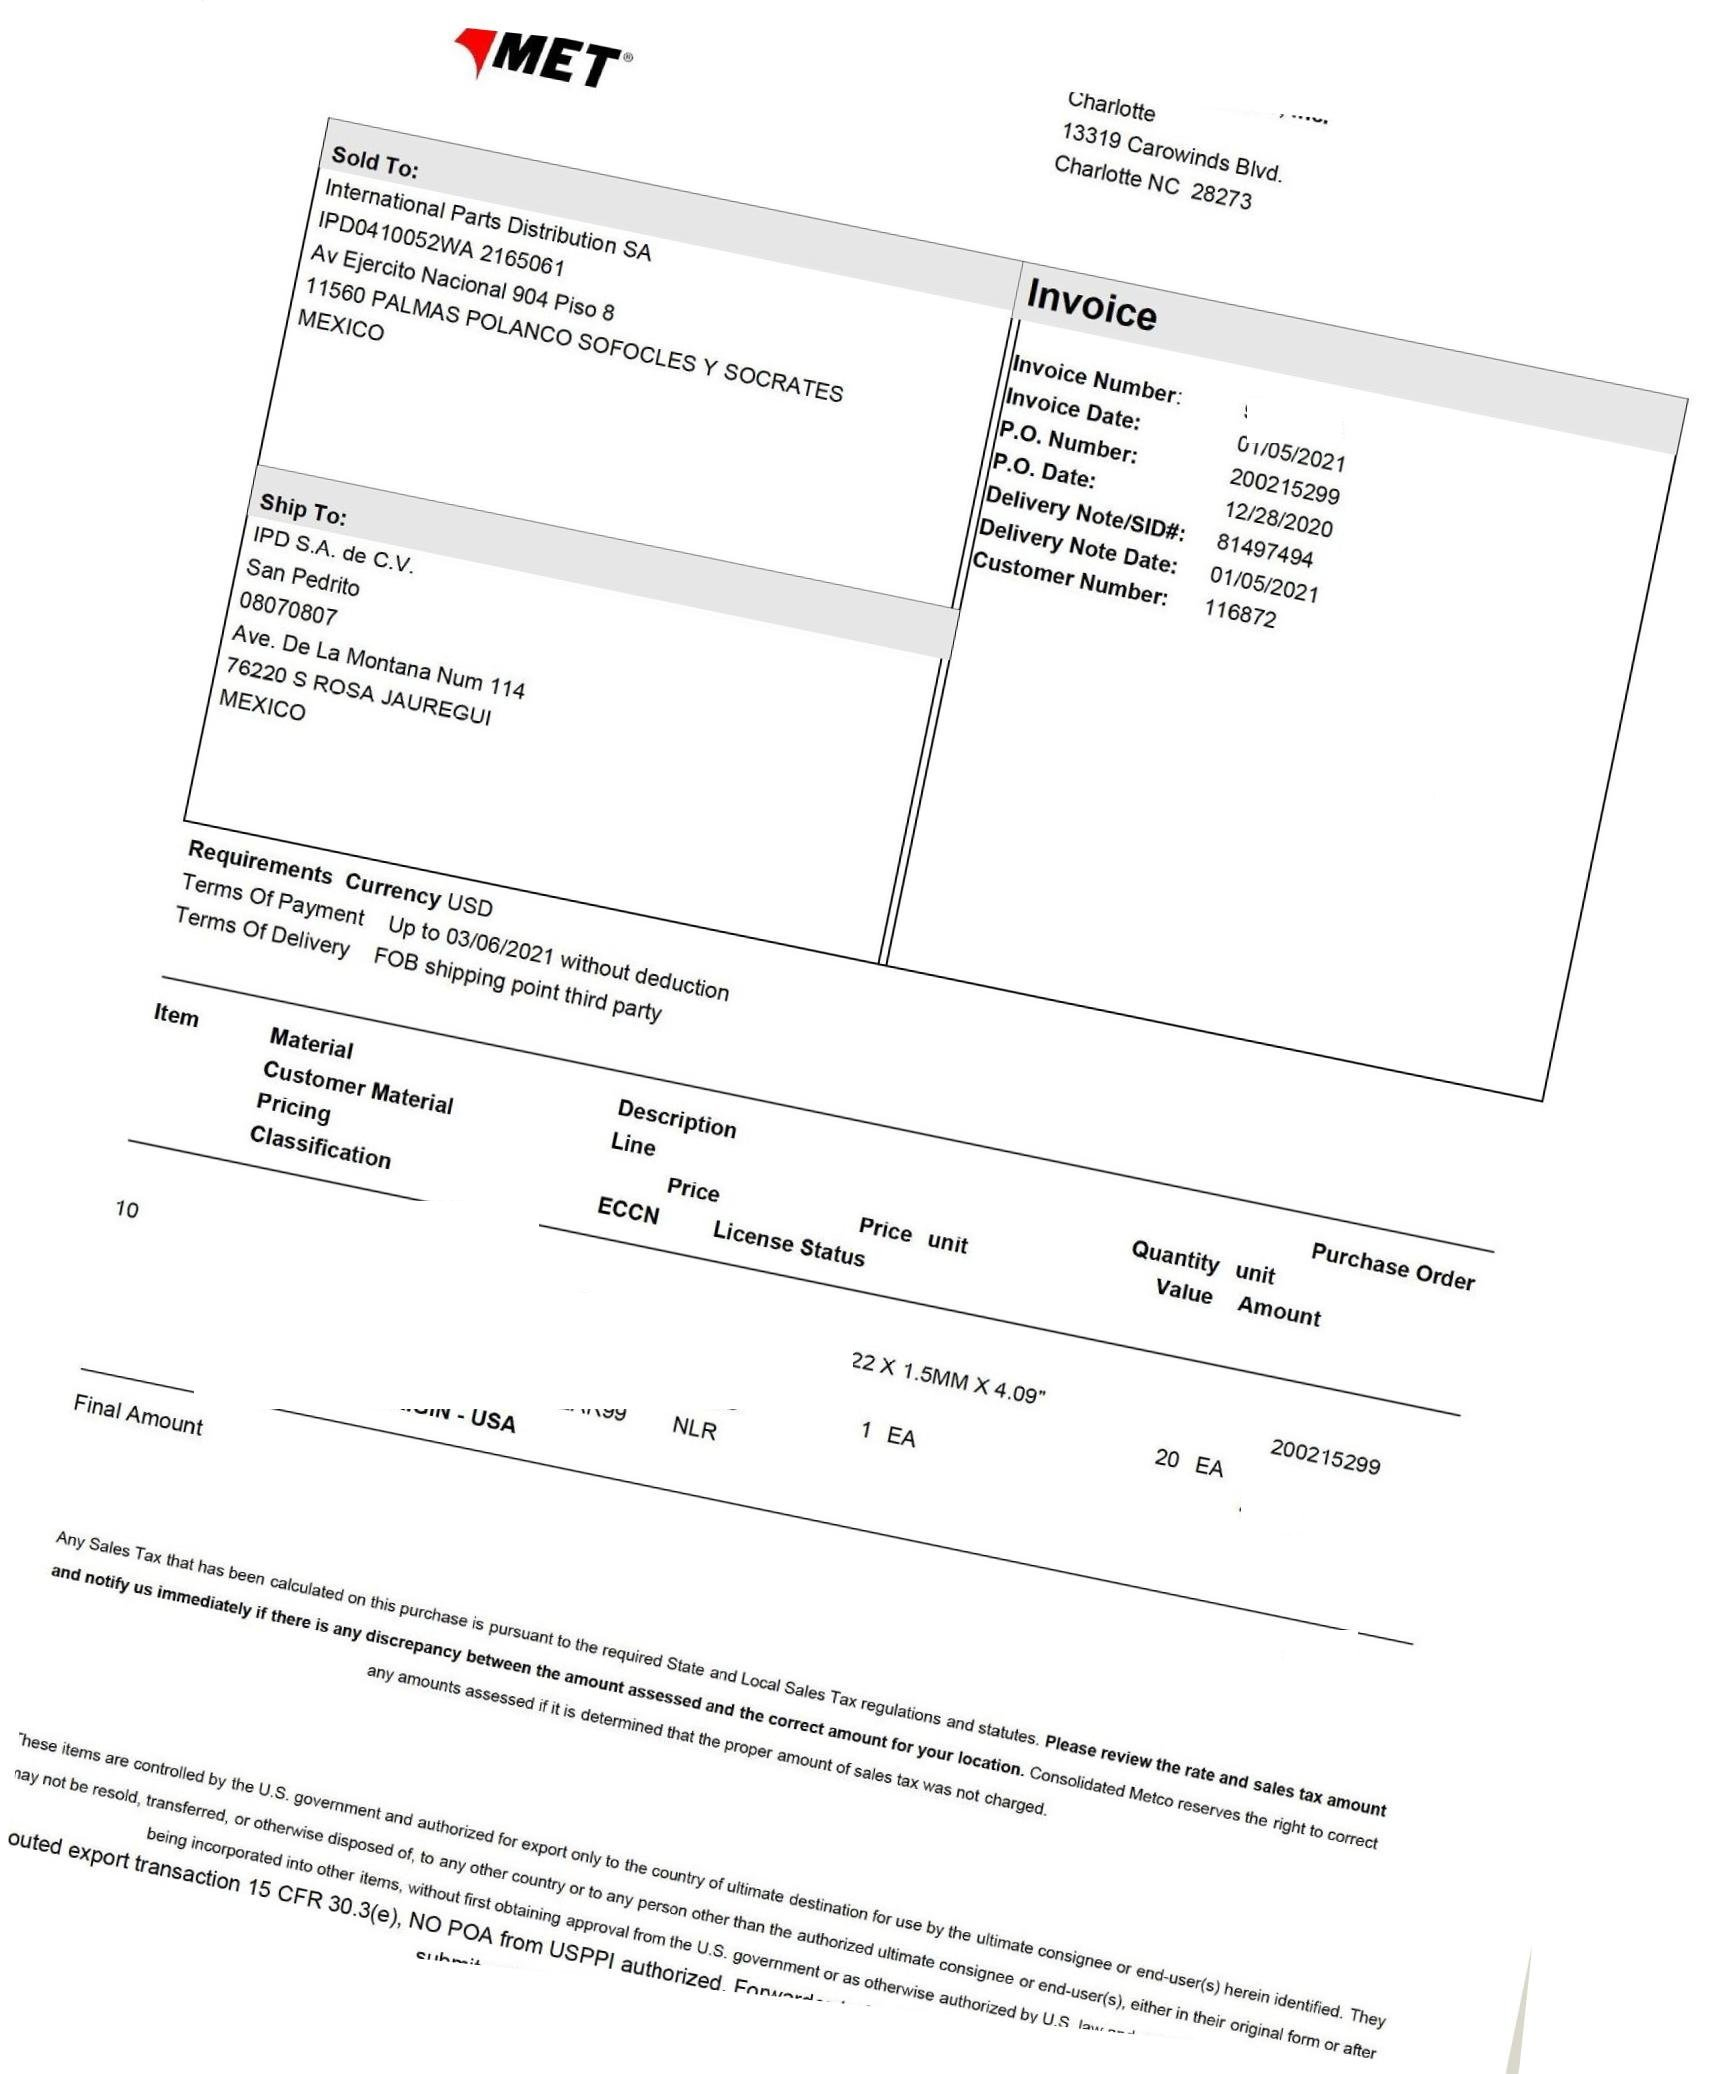

In [38]:
pil_img = Image(filename=input_file)
display(pil_img)

# Input Image - Tilted image

In [39]:
deskew_obj = Deskew(input_file, display_image, output_file, r_angle)
deskew_obj.run()

---Img height, width -------->{},{} 2074 1720
Raw angle- {} -77.93296089385476
-----------rot_angle----------->{} 12.067039106145245
---****Rotation required****------
------------self.output_file===>
/home/ustuser/official/AIBeta/smartvision2021/hackathon/NameNormImg/testimage_output/Jupy_rotated_V2_Mask_Mild_orient_1.1.jpg
[OSD] Page number: 0
Orientation in degrees: 0
Rotate: 0
Orientation confidence: 5.37
Script: Latin
Script confidence: 6.00

[ANGLE] 0.0


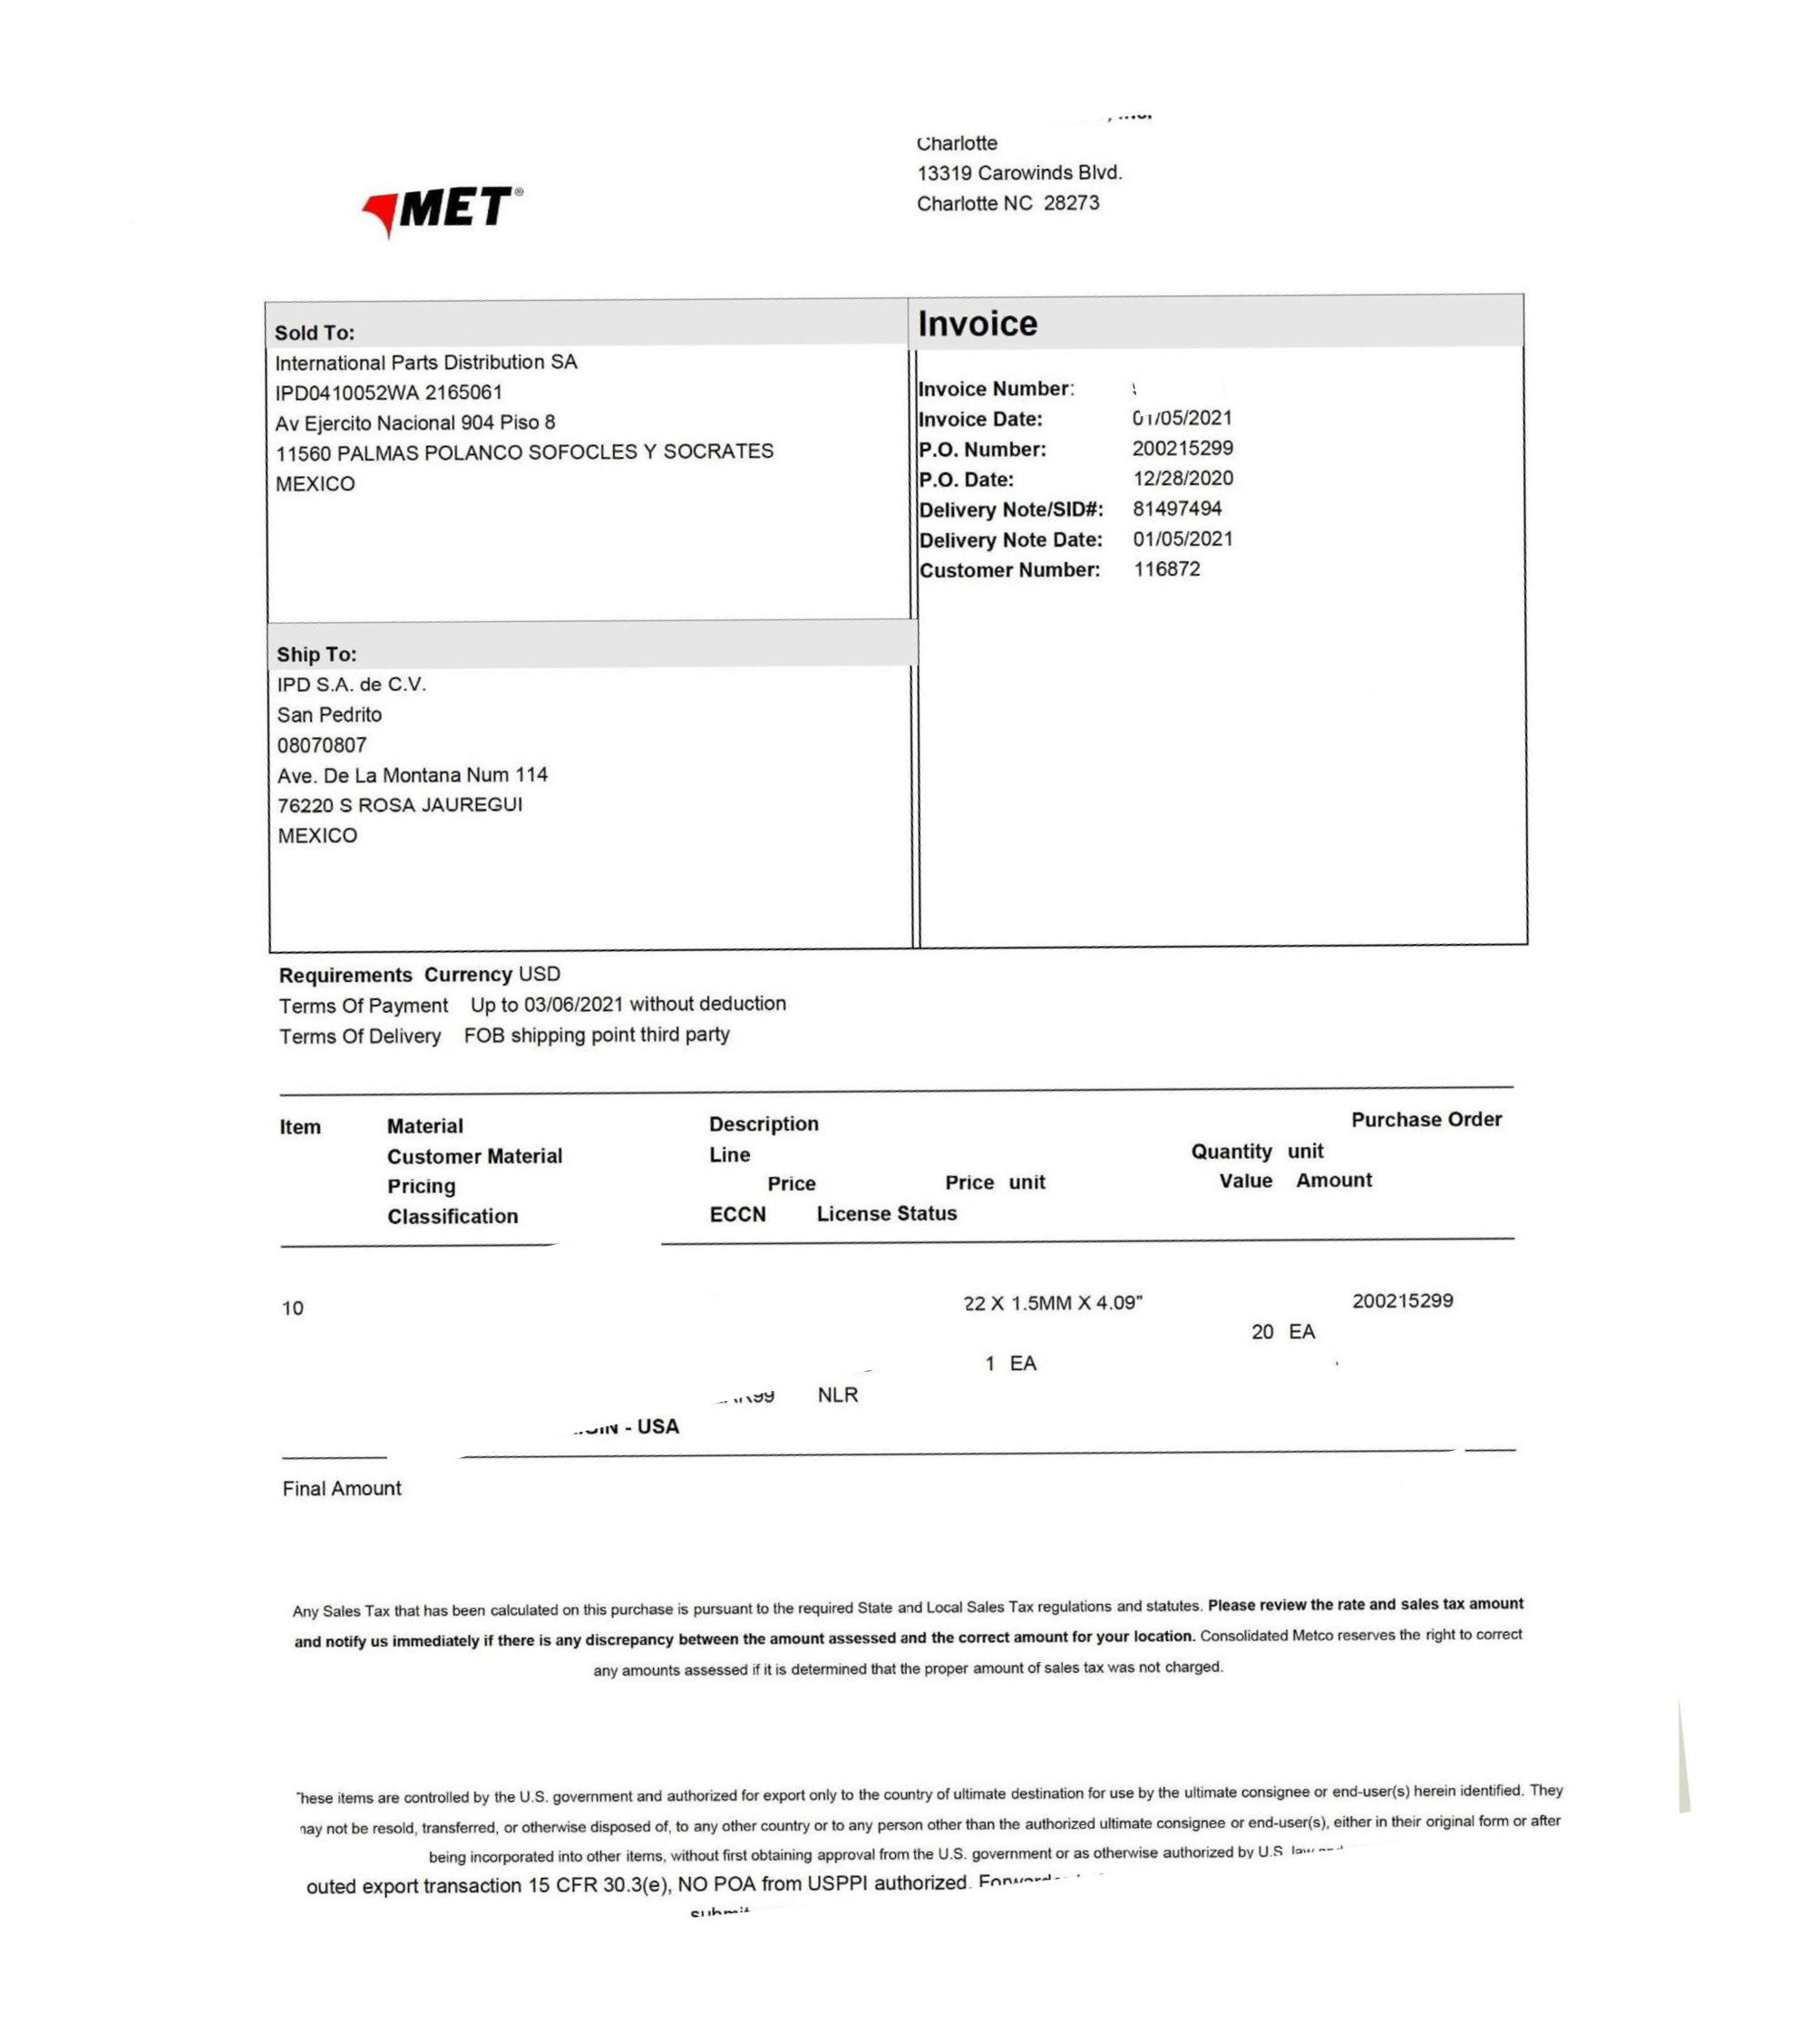

In [41]:
out_pil_img = Image(filename=output_file)
display(out_pil_img)

# Orientation corrected output image